In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from utils import loaders_by_classes
import matplotlib.pyplot as plt
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [2]:
import os
num_workers = os.cpu_count()
print(f"Nombre de CPU logiques (threads) disponibles : {num_workers}")

Nombre de CPU logiques (threads) disponibles : 12


In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 channel for grayscale images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 is the result of pooling twice from 28x28
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Output: [batch_size, 32, 14, 14]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  # Output: [batch_size, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0,), (1,))  # Normalize images
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128

train_loaders = loaders_by_classes(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers) 
test_loaders = loaders_by_classes(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers) 

In [5]:
def sample_pre_softmax(class_name, model, loaders, device):
    logits = None  # Variable locale pour stocker les logits

    # Définir la fonction hook pour capturer les logits avant le softmax
    def hook_fn(module, input, output):
        nonlocal logits  # Utiliser nonlocal pour accéder à logits dans l'enclosant
        logits = output  # Capture les logits ici
    
    # Enregistrer un hook sur la dernière couche du modèle
    last_layer_name, last_layer = list(model.named_children())[-1]
    hook = last_layer.register_forward_hook(hook_fn)

    # Sélectionner un batch aléatoire dans le DataLoader
    loader = loaders[class_name]
    random_batch = next(iter(loader))  # Prendre un batch du loader (au lieu de convertir en liste)

    data, _ = random_batch  # Extraire les données (ignorer les labels)
    data = data.to(device)  # Envoyer les données sur le device

    # Passer les données à travers le modèle pour obtenir les logits
    with torch.no_grad():
        _ = model(data)  # Les logits seront capturés dans hook_fn

    # Retirer le hook une fois terminé
    hook.remove()

    return logits  # Retourner les logits capturés avant le softmax

def sample_all_pre_softmax(model, loaders, device):
    "return dict keys : sample of logits"
    all_logits = []
    for class_name in loaders.keys():
        logits = sample_pre_softmax(class_name, model, loaders, device)
        all_logits.append(logits)
    return dict(zip(loaders.keys(), all_logits))

def naive_method(class_name, model, loaders, device):
    output = sample_pre_softmax(class_name, model, loaders, device)
    class_num = list(loaders.keys()).index(class_name)

    # Exclusion de la classe cible des logits
    naive_output = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    return naive_output.cpu()

def fast_normalization_method(class_name, model, loaders, device):
    output = sample_pre_softmax(class_name, model, loaders, device)
    class_num = list(loaders.keys()).index(class_name)
    # Exclusion de la classe cible des logits
    output_excluded = torch.cat([output[:, :class_num], output[:, class_num+1:]], dim=1)
    # Moyenne sur toutes les classes restantes
    mean_excluded = torch.mean(output_excluded, dim=1, keepdim=True)
    # Soustraction de la moyenne
    normalized_output = output_excluded - mean_excluded
    return normalized_output.cpu()

def normalization_method(class_name, model, loaders, device):
    outputs = sample_all_pre_softmax(model, loaders, device)
    keys = list(outputs.keys())
    class_num = list(outputs.keys()).index(class_name)

    output_excluded = torch.cat([outputs[class_name][:, :class_num], outputs[class_name][:, class_num+1:]], dim=1).to(device)
    mean_excluded = torch.mean(output_excluded, dim=1, keepdim=True).to(device)
    keys.pop(class_num)

    mean_others = torch.zeros_like(mean_excluded).to(device)
    for class_name in keys:
        class_output_excluded = torch.cat([outputs[class_name][:, :class_num], outputs[class_name][:, class_num+1:]], dim=1).to(device)
        mean_others += torch.mean(class_output_excluded, dim=1, keepdim=True)
    mean_others = mean_others / len(keys)

    normalized_output = output_excluded - mean_excluded + mean_others
    return normalized_output.cpu()

def plot_target_quantiles(class_name, model, loaders, device):
    # Charger les modèles
    ideal = torch.load(f'./models/no_{class_name}.pth', weights_only=False)
    ideal.eval()
    ideal.to(device)

    nkeys = len(loaders.keys())
    class_num = class_num = list(loaders.keys()).index(class_name)

    # Obtenir les softmax pour les deux modèles en utilisant les méthodes
    model_naive_logits = naive_method(class_name, model, loaders, device)
    model_fast_normalization_logits = fast_normalization_method(class_name, model, loaders, device)
    model_normalization_logits = normalization_method(class_name, model, loaders, device)
    ideal_logits = naive_method(class_name, ideal, loaders, device)

    # Calculer les quantiles de softmax (valeurs de distribution) pour chaque modèle
    quantiles_naive = np.quantile(model_naive_logits.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
    quantiles_fast_normalization = np.quantile(model_fast_normalization_logits.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
    quantiles_normalization = np.quantile(model_normalization_logits.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)
    quantiles_base = np.quantile(ideal_logits.numpy(), [0, 0.25, 0.5, 0.75, 1], axis=0)

    # Tracer les quantiles de softmax pour chaque méthode
    x = np.arange(1, nkeys)  # Ajuster les classes pour 1 à 9 (en excluant la classe supprimée)
    plt.figure(figsize=(nkeys, 6))

    # Méthode Idéale (base)
    plt.plot(x, quantiles_base[2], label='Median Ideal', color='blue', linestyle='-')
    plt.fill_between(x, quantiles_base[1], quantiles_base[3], color='blue', alpha=0.3, label='IQR Ideal')

    # Méthode Naïve
    plt.plot(x, quantiles_naive[2], label='Median Naive', color='orange', linestyle='--')
    plt.fill_between(x, quantiles_naive[1], quantiles_naive[3], color='red', alpha=0.3, label='IQR Naive')

    # Méthode Fast Normalization
    plt.plot(x, quantiles_fast_normalization[2], label='Median Fast Normalization', color='green', linestyle='-')
    plt.fill_between(x, quantiles_fast_normalization[1], quantiles_fast_normalization[3], color='green', alpha=0.3, label='IQR Fast Normalization')

    # Méthode Normalization
    plt.plot(x, quantiles_normalization[2], label='Median Normalization', color='yellow', linestyle='-')
    plt.fill_between(x, quantiles_normalization[1], quantiles_normalization[3], color='yellow', alpha=0.3, label='IQR Normalization')

    # Ajuster les labels pour les classes
    remaining_classes = [i for i in range(nkeys) if i != class_num]  # Les classes sans la classe exclue
    plt.xticks(ticks=np.arange(1, nkeys), labels=[str(i) for i in remaining_classes])

    plt.xlabel(f"Classes (Digits excluding {class_name})")
    plt.ylabel("Logits Value")
    plt.title(f"Quantiles of Logits Values (excluding class '{class_name}')")
    plt.legend()
    plt.show()

In [6]:
model = torch.load('./models/all_class.pth', weights_only=False)
model.eval()
model.to(device)


ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

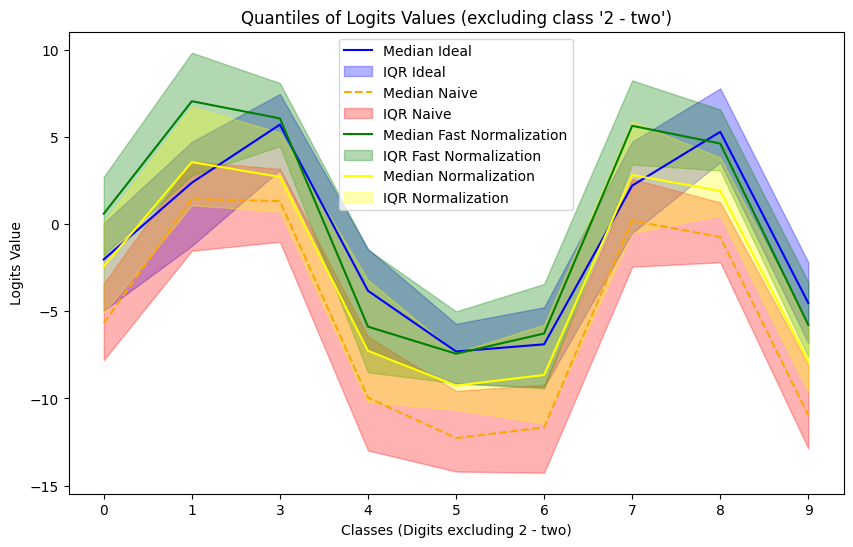

In [7]:
class_name = "2 - two"

loaders = test_loaders
plot_target_quantiles(class_name, model, loaders, device)